 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Obtaining the data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Downloading-the-data" data-toc-modified-id="Downloading-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Downloading the data</a></span></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Exploring-the-data" data-toc-modified-id="Exploring-the-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Exploring the data</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Loading-the-data-into-Python" data-toc-modified-id="Loading-the-data-into-Python-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading the data into Python</a></span></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#A-model-for-$CO_2$-concentration" data-toc-modified-id="A-model-for-$CO_2$-concentration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A model for $CO_2$ concentration</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#A-linear-trend-model" data-toc-modified-id="A-linear-trend-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>A linear trend model</a></span></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#A-quadratic-model" data-toc-modified-id="A-quadratic-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>A quadratic model</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Solving-the-problem-using-linear-algebra" data-toc-modified-id="Solving-the-problem-using-linear-algebra-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Solving the problem using linear algebra</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#Solution-using-np.linalg.lstsq" data-toc-modified-id="Solution-using-np.linalg.lstsq-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Solution using <code>np.linalg.lstsq</code></a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/MaunaLoa.ipynb#A-model-with-seasonality" data-toc-modified-id="A-model-with-seasonality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>A model with seasonality</a></span></li></ul></div>

# Fitting to the Mauna Loa $CO_2$ record

## Introduction

$CO_2$ concentration in the atmosphere has been steadily increasing. The flask measurements collected in Mauna Loa provide a fairly long time series that allows us to see the temporal evolution of this trace gas. In this notebook, we just want to display the data, and play with it a bit. The time series looks like this

![Mauna Loa CO2 record](https://www.pmel.noaa.gov/co2/files/co2_data_mlo_med.jpg)

We first start by **importing some important Python packages for this analysis**

In [1]:
import os # Checks for files and so on
import numpy as np # Numpy for arrays and so on
import matplotlib.pyplot as plt # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

import urllib2 # to get hold of the data, stored in an FTP site


## Obtaining the data

### Downloading the data

The data are available on line from [NOAA](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). We want the monthly  average dataset, which can be found there. If the data is not yet available in your system, the next Python cell will download it from [`ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt`](ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt). In this case, because the url is an FTP one we will use the `urllib2` package rather than requests, that doesn't deal with FTP. We will save it to a file with the same name locally:

In [2]:
if not os.path.exists("co2_mm_mlo.txt"):
    # Data file not present, let's download it
    r = urllib2.urlopen("ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt")
    with open("co2_mm_mlo.txt", 'w') as fp:
        for line in r.readlines():
            fp.write(line)


### Exploring the data

We can have a peek at the text file. We note that most of the first few lines are "comments" (lines start by `#`), which describe useful *metadata*. We note that we have several columns of data:

1. The year
2. The month
3. The decimal date
4. The monthly mean CO2 mole fraction determined from daily averages

We will mostly be bothered about columns three and four.


We can peek at the data (first 73 lines) using the UNIX shell [`head`](http://www.linfo.org/head.html) command (this will not work on Windows, but will probably work on OSX):

In [3]:
!head -n 73 co2_mm_mlo.txt

# --------------------------------------------------------------------
# USE OF NOAA ESRL DATA
# 
# These data are made freely available to the public and the
# scientific community in the belief that their wide dissemination
# will lead to greater understanding and new scientific insights.
# The availability of these data does not constitute publication
# of the data.  NOAA relies on the ethics and integrity of the user to
# insure that ESRL receives fair credit for their work.  If the data 
# are obtained for potential use in a publication or presentation, 
# ESRL should be informed at the outset of the nature of this work.  
# If the ESRL data are essential to the work, or if an important 
# result or conclusion depends on the ESRL data, co-authorship
# may be appropriate.  This should be discussed at an early stage in
# the work.  Manuscripts using the ESRL data should be sent to ESRL
# for review before they are submitted for publication so we can
# insure that the quality and lim

## Loading the data into Python

This is quite straightforward using [`np.loadtxt`](https://scipython.com/book/chapter-6-numpy/examples/using-numpys-loadtxt-method/)...

We will also "mask" if the data is missing checking for the value -99.99...

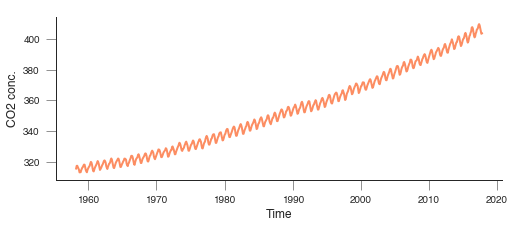

In [4]:
co2 = np.loadtxt("co2_mm_mlo.txt", usecols=[2,3])
ok_data = co2[:, 1] > 0

co2[np.logical_not(ok_data), 1] = np.nan

plt.figure(figsize=(8,3))
plt.plot(co2[ok_data, 0], co2[ok_data,1], '-')
plt.xlabel("Time")
plt.ylabel("CO2 conc.")



So this is quite similar to what we had above. 

## A model for $CO_2$ concentration

### A linear trend model

We might be curious about a simple model for $CO_2$ concentration. Perhaps the simplest model is a linear trend, which we can write as the concentration at some time step $i$, $W_i$ being just a linear scaling of the time $x_i$:

$$
W_i = m \cdot x_i + c.
$$

We can define a Python function for this very easily:

In [5]:
def linear_model(p, x):
    m, c = p
    return m*x + c


We can now try to plot some model trajectories and the data by supplying parameters for the slope ($m$) and intercept ($c$). Let's start by assuming that the slope can be approximated by the difference between minimum and maximum concentrations divided  by the number of timesteps:

$$
m \approx  \frac{403-305}{716}
$$

$c$ is the minimum value, so $c\approx 305$.

Sum of squared residuals: 14410.7445911


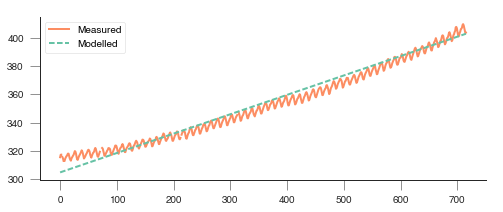

In [6]:
x = np.arange(716)
plt.figure(figsize=(8,3))
plt.plot(x, co2[:,1], '-', label="Measured")
m = (403.-305.)/716
c = 305.
plt.plot(x, linear_model([m,c], x), '--', label="Modelled")
plt.legend(loc="best")
S = np.sum((linear_model([m,c], x[ok_data])- co2[ok_data,1])**2)
print "Sum of squared residuals: {}".format(S)

So, not really a great fit... The overall shape is a bit off, and the model isn't really fitting the annual seasonality in the curve. 

### A quadratic model

Maybe we need a higher order model, like a quadratic model:

$$
W_i = a_0 \cdot x_i^2  + a_1 \cdot x_i + a_2.
$$

In this case, it is a bit harder to eyeball what good starting parameters for $\left[a_0, a_1, a_2\left]$ would be. A strategy for this would be to consider what a good fit would look like, and then use this to define a metric of good fit. A good fit would basically overlap the measurements, being indistinguishable from them. The *residual* is the difference between the measurement and the model. In this case, it can be positive or negative (whether the model over- or undershoots the observations), but by squaring the residual we get rid of the sign. Then we can add up all the squared residuals, and the best fit will be the one that has the lowest sum of squares. This is in essence the [method of least squares](https://en.wikipedia.org/wiki/Least_squares). Let's see how this works *intuitevely*: we'll loop over the parameters and plot the different predicted concentrations... First we need our model function...

In [7]:
def quadratic_model(p, x):
    a0, a1, a2 = p
    return a0*x**2 + a1*x + a2

A = np.array([[716**2, 716], [300*300, 300]])
b = np.array([403-315, 340-315])
print np.linalg.solve(A,b)

[  9.51242659e-05   5.47960536e-02]


We can get a feeling of what the parameters might be just by eyeballing reading up some points from the graph, and then solving the system manually:

$$
\begin{align}
403 &= a_0\cdot (716)^2 + a_1\cdot (716) + a_2\\
340 &= a_0\cdot (300)^2 + a_1\cdot (300) + a_2\\
315 &= a_0\cdot (0)^2 + a_1\cdot (0) + a_2\\
\end{align}
$$

From this, we can get some rough estimates, which in this case are

$$
\begin{align}
a_0 &= 9.5\cdot 10^{-5}\\
a_1 &= 5.48\cdot 10^{-2}\\
a_2 &= 315.\\
\end{align}
$$

We can just basically run the model around these numbers and plot the different model predictions with a loop over $a_0$ and another one over $a_1$ (assuming $a_2$ is well defined)

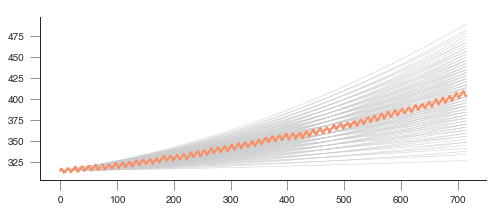

In [8]:
plt.figure(figsize=(8,3))

a2 = 315.
for a0 in np.linspace(1e-5, 20e-5, 10):
    for a1 in np.linspace(1e-2, 10e-2, 10):
        plt.plot( x, quadratic_model([a0, a1, a2], x), '-', lw=0.5, c="0.8")
        
plt.plot(x, co2[:,1], '-', label="Measured")

This is quite complicated, we can see that there might be a good line of fit, but we don't see clearly what parameters provide it! We can store the goodness of fit metric (sum of squared residuals) in a 2D array and then plot it as an image. It should be more obvious where the minimum lies...

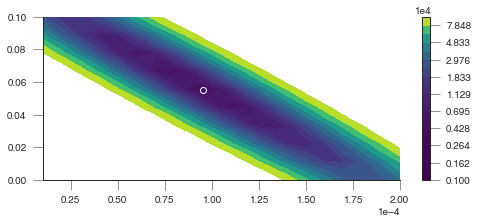

In [9]:
# Define a 2D array for the sum of squares (sos)
sos = np.zeros((10, 20))
# the time axis redefined again, in case it got confused with something else
x = np.arange(716)

# first loop is over a0, 20 steps between 1e-5 and 20e-5
for ii, a0 in enumerate(np.linspace(1e-5, 20e-5, 20)):
    # 2nd loop is over a1, 10 steps between 1e-2 and 10e-2
    for jj, a1 in enumerate(np.linspace(1e-2, 10e-2, 10)):
        # for the current values of a0 and a1, calculate the residual
        residual = quadratic_model([a0, a1, a2], x[ok_data]) - co2[ok_data, 1]
        sq_residual = residual*residual
        sum_of_residuals = sq_residual.sum()
        # Store the sum_of_residuals into our array
        sos[jj, ii] = np.sum((quadratic_model([a0, a1, a2], x)[ok_data] - co2[ok_data, 1])**2)
# Plotting!
plt.figure(figsize=(8,3))
# Set up the x and y axis for the plot
yy = np.linspace(1e-5, 20e-5, 20)
xx = np.linspace(1e-5, 10e-2, 10)
# Do a contour plot. The logspace bit basically defines the location 
# of 20 contour lines
c = plt.contourf(yy, xx, sos, np.logspace(3,5,20))
# Colorbar
plt.colorbar()
# Now, just plot the rough guess of a0 and a1 into this plot
# We want to plot an empty circle with a white edge
plt.plot(9.51242659e-05, 5.47960536e-02, 'o', mfc="None", mec="w")



So that's pretty interesting, we get a very clear "valley", with a minimum pretty close to where our first rough guess is... Let's find out where the actual minimum from our brute-force approach is. We can do this quickly by creating a mask where all the elements are `False` except where the minimum value of `sos` is located. We can then use this mask to multiply our `x` and `y` axes and just select the unique values that are larger than 0.

In [10]:
print "Best SoS: {:g}".format(sos.min())
sos_mask = sos == sos.min()
u1 = np.unique(yy[None, :]*sos_mask)
yy_opt = u1[u1 > 0]
u2 = np.unique(xx[:, None]*sos_mask)
xx_opt = u2[u2 > 0]

Best SoS: 4090.62


We can plot now the cost function, as well as our first rough guess and the final guess:

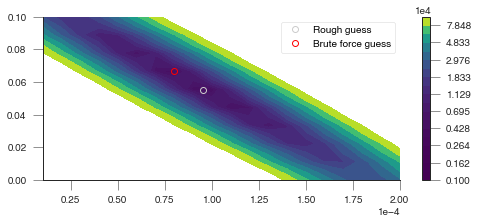

In [11]:
# Plotting!
plt.figure(figsize=(8, 3))
# Set up the x and y axis for the plot
yy = np.linspace(1e-5, 20e-5, 20)
xx = np.linspace(1e-5, 10e-2, 10)
# Do a contour plot. The logspace bit basically defines the location
# of 20 contour lines
c = plt.contourf(yy, xx, sos, np.logspace(3, 5, 20))
# Colorbar
plt.colorbar()
# Now, just plot the rough guess of a0 and a1 into this plot
# We want to plot an empty circle with a white edge
plt.plot(
    9.51242659e-05,
    5.47960536e-02,
    'o',
    mfc="None",
    mec="0.8",
    label="Rough guess")
plt.plot(yy_opt, xx_opt, 'o', mfc="None", mec="r", label="Brute force guess")
plt.legend(loc="best")

That's not *too bad*! But althogh we found a minimum, we haven't shown how well our model really fits the observations! Let's plot the prediction (with the "optimised parameters" as well as the roughly guessed ones):

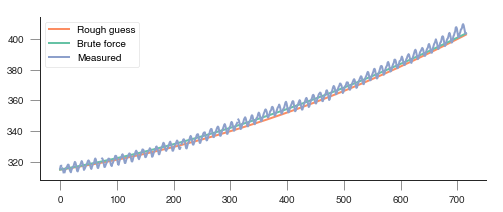

In [12]:
plt.figure(figsize=(8, 3))

a2 = 315.

plt.plot(
    x,
    quadratic_model([9.51242659e-05, 5.47960536e-02, a2], x),
    '-',
    label="Rough guess")
plt.plot(x, quadratic_model([yy_opt, xx_opt, a2], x), '-', label="Brute force")

plt.plot(x, co2[:, 1], '-', label="Measured")
plt.legend(loc="best")

## Solving the problem using linear algebra 

So we can see that our brute force search has given us a better fit, which is what one expectes. It should be possible to solve this analytically. Let's write this as a matrix problem:

$$
\begin{align*}
\mathbf{A}\cdot\vec{x}&=\vec{y}\\
\mathbf{A}&=\begin{bmatrix} 
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
x_3^2 & x_3 & 1 \\
\vdots & \vdots \vdots \\
x_N**2 & x_N & 1 \\\end{bmatrix}\\
\vec{x} &=\begin{bmatrix}a_0\\a_1\\a_2 \end{bmatrix}\\
\vec{y} &=\begin{bmatrix}W_1\\W_2\\W_3\\ \vdots \\W_N \end{bmatrix}\\
\end{align*}
$$

So, we see that this is really an overdetermined linear problem, where we've got more observations ($N$) than parameters (3). We can solve this by calculating the pseudo inverse:

$$
\vec{x} = \left[\mathbf{A}^{\top}\mathbf{A}  \right]^{-1}\vec{y},
$$
where $^{\top}$ is the **transpose**, and $^{-1}$ is the inverse matrix. We can solve this problem easily in Python, which can deal with linear algebra nicely. The [`np.linalg.lstsq`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html) method has a direct solver, or you can also work it out by calculating the inverse matrix yourself. The latter approach is usually numerically more unstable, so we won't be looking into it.

### Solution using `np.linalg.lstsq`

In this case, we need to define the matrix $\mathbf{A}$. The observations vector $\vec{y}$ is already defined. What is needed is to weed out the invalid measurements in both $\mathbf{A}$ and $\vec{y}$. We then use [`np.linalg.lstsq`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html) to solve the linear overdetermined system. This returns a number of things:

1. The solution vector.
2. The sum of squared residuals.
3. The rank of the matrix $\mathbf{A}$.
4. The eigenvalues.

We're really only interested in the first two (the other two outputs are important, but this is not your methods course!).

In [13]:
# We create the A matrix
x = np.arange(716)[ok_data]
A = np.array([x**2, x, np.ones_like(x)])
# Now put the observations into y
y = co2[ok_data, 1]

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
rough_guess = [9.51242659e-05, 5.47960536e-02, 315]
brute_force = [yy_opt, xx_opt, 315]
print "Parameter   Matrix       Brute force     Rough guess"
for par in range(3):
    print "a{}:         {:08.5e}\t {:08.5e}\t {:08.5e}".format(
        par, xopt[par], float(brute_force[par]), rough_guess[par])
print "Sum of residuals: {:g}".format(float(sum_of_residuals))

Parameter   Matrix       Brute force     Rough guess
a0:         8.70644e-05	 8.00000e-05	 9.51243e-05
a1:         6.58749e-02	 6.66700e-02	 5.47961e-02
a2:         3.14395e+02	 3.15000e+02	 3.15000e+02
Sum of residuals: 3470.24


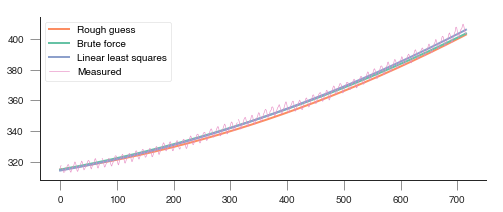

In [14]:
plt.figure(figsize=(8, 3))
x = np.arange(716)
a2 = 315.

plt.plot(
    x,
    quadratic_model(rough_guess, x),
    '-',
    label="Rough guess")
plt.plot(x, quadratic_model([yy_opt, xx_opt, a2], x), '-', label="Brute force")
plt.plot(x, quadratic_model(xopt, x), '-', label="Linear least squares")

plt.plot(x, co2[:, 1], '-', lw=0.6, label="Measured")
plt.legend(loc="best")

So we can see that the optimal value is quite similar to the other two solutions, but results in a better fit (3470 versus 4090). We can see that with this method we can solve for all three parameters, even though our first guess of 315 for $a_2$ was pretty close to the true solution. 

## A model with seasonality

While the quadratic model appears to go through the centre of the Mauna Loa curve, it clearly misses an important feature: the seasonality of the $CO_2$ concentration. We can't really emulate that behaviour with a simple quadratic function, but need a different model, one that deals with the seasonality. We can think that the seasonality is an additive cosine term, so that our model for $CO_2$ concentration is now

$$
W_i = a_0\cdot x_i^2 + a_1\cdot x_i + a_2 + a_3\cdot \cos\left(2\pi\frac{x}{T}  \right),
$$
where $T$ is the period of the seasonality, in this case, annual so $T=12$.

We can solve this problem as before, noting that our $\mathbf{A}$ matrix is now given by 

$$
\mathbf{A}=\begin{bmatrix}  
x_1^2 & x_1 & 1 & \cos \left( 2\pi\frac{x_1}{T}\right)\\
x_2^2 & x_2 & 1 & \cos \left( 2\pi\frac{x_2}{T}\right)\\
x_3^2 & x_3 & 1 & \cos \left( 2\pi\frac{x_3}{T}\right)\\
\vdots & \vdots & \vdots & \vdots \\
x_N^2 & x_N & 1 & \cos \left( 2\pi\frac{x_N}{T}\right)\\
\end{bmatrix}.
$$

We can still solve the problem by making use of `lstsq`. Let's see how that works!

a0:         8.72324e-05
a1:         6.57658e-02
a2:         3.14417e+02
[ 1614.6445079]


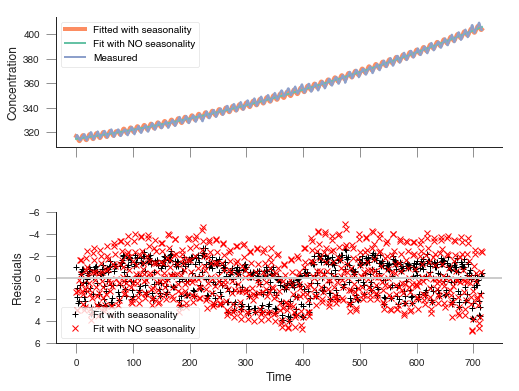

In [15]:
period = 12.
def quadratic_with_season (p, x):
    a0, a1, a2, a3 = p
    return a0*x*x + a1*x + a2 + a3*np.cos(2*np.pi*(x/period))

# We create the A matrix
x = np.arange(716)[ok_data]
A = np.array([x*x, x, np.ones_like(x), np.cos(2*np.pi*(x/period))])
# Now put the observations into y
y = co2[ok_data, 1]

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
for par in range(3):
    print "a{}:         {:08.5e}".format(
        par, xopt[par])
print sum_of_residuals

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))


axs[0].plot(
    x,
    quadratic_with_season(xopt, x),
    '-', lw=4, label="Fitted with seasonality")
axs[0].plot(x, quadratic_model([8.70644e-05, 6.58749e-02, 3.14395e+02], x), '-',
           label="Fit with NO seasonality" )

axs[0].plot(x, co2[ok_data, 1], '-', label="Measured")
axs[0].legend(loc="best")
axs[1].plot(x, co2[ok_data, 1] -  quadratic_with_season(xopt, x), 'k+', label="Fit with seasonality"  )
axs[1].plot(x, co2[ok_data, 1] - quadratic_model([8.70644e-05, 6.58749e-02, 3.14395e+02], x), 'rx',
           label="Fit with NO seasonality" )
axs[1].set_ylim(6, -6)
axs[1].axhline(0, c="0.8")
axs[0].set_ylabel("Concentration")
axs[1].set_ylabel("Residuals")
axs[1].set_xlabel("Time")
axs[1].legend(loc="best")


So that's pretty good: by adding a simple cosine term, we can now start to model the annual seasonality in the measurements, and the sum of squared residuals is now further shrunk to 1614. This is good, but in some ways unsurprising: you're now solving for 4 parameters, rather than 3 or 2 (for the simple linear case), so you have more degrees of freedom, and you expect to be able to fit your data better. 

... But that's just enough for today ;-)